# **IHLT - Project**

# **1. Introduction**

In this project, we are working with ...

https://smedina-upc.github.io/ihlt/sts/index.html#1

- The model is the most important hyperparameter.
- For example, Random Forest works generally well but there are other models that work better.
    - Tip: Try models that make sense.
- Trying 3 algorithm should be enough.
- Trick: Take a look at the paper and some teams considered in some way the datasets. We only use the europa corpus. We have 3 datasets for this project? Maybe some techniques work better for ones and better for the others. Be careful, to not use the type of document as an input (we are informing the model too much).
- It is better to use a single model (and not have different models depending on the input.txt).
- Podem fer-ho tot en un notebook o separar-ho en múltiples notebooks.
- For the presentation: It is important the questions that we do and the answers we provide.

# **2. Data Loading**

In this section, we load the training and test datasets along with their corresponding gold standard similarity scores from various corpora. We begin by installing and importing the necessary libraries and packages. Next, we define a function to load and process the datasets, and we transform them into structured DataFrames for further analysis.

In [1]:
# Install the necessary libraries
!pip install pandas
!pip install nltk
!pip install wikipedia-api
!pip install wiktionaryparser

In [2]:
# Import the required libraries

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer

from nltk.corpus import wordnet as wn
from math import log
from itertools import product

import os

import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaccard_distance
import wikipediaapi
import warnings
import re

# Download necessary NLTK data files
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet_ic')

stopwords = set(stopwords.words('english'))
from nltk.corpus import wordnet_ic

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-d

In [13]:
# Mount Google Drive to access stored datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

def load_dataset(directory, dataset_category='train'):
    """
    Loads the dataset from the specified directory.

    Parameters:
        directory (str): Path to the main data directory.
        dataset_category (str): Category of the dataset to load ('train' or 'test').

    Returns:
        list: A list of tuples containing sentence pairs, similarity scores, and dataset names.
    """
    file_inputs, file_gs = [], []

    # Determine the folder path based on the dataset category
    folder_path = os.path.join(directory, 'train' if dataset_category == 'train' else 'test-gold')

    # Collect input files
    file_inputs = [
        os.path.join(folder_path, fname)
        for fname in os.listdir(folder_path)
        if fname.startswith('STS.input') or fname.startswith('STS.input.surprise')
    ]

    # Collect gold standard files
    file_gs = [
        os.path.join(folder_path, fname)
        for fname in os.listdir(folder_path)
        if (fname.startswith('STS.gs') or fname.startswith('STS.gs.surprise')) and not fname.endswith('ALL.txt')
    ]

    combined_data = []

    # Process each pair of input and gold standard files
    for input_path, gs_path in zip(sorted(file_inputs), sorted(file_gs)):
        base_name = os.path.basename(input_path).split('.')[2]
        if base_name.startswith('surprise'):
            base_name = '.'.join(os.path.basename(input_path).split('.')[2:4])

        with open(input_path, 'r', encoding='utf-8') as inp_file, open(gs_path, 'r', encoding='utf-8') as gs_file:
            input_pairs = [line.strip().split('\t') for line in inp_file]
            gs_scores = [float(line.strip()) for line in gs_file]

            combined_data.extend(
                [
                    (pair[0], pair[1], score, base_name)
                    for pair, score in zip(input_pairs, gs_scores)
                ]
            )

    return combined_data

In [4]:
data_dir = './datasets/'     # Replace with your data directory path (Marc)
#data_dir = '/content/drive/MyDrive/MAI/IHLT/Project/'  # Replace with your data directory path (Joan)

# Load training data
train_data = load_dataset(data_dir, dataset_category='train')
columns = ['sentence_0', 'sentence_1', 'score', 'dataset_name']
train_data = pd.DataFrame(train_data, columns=columns)

# Load test data
test_data = load_dataset(data_dir, dataset_category='test')
columns = ['sentence_0', 'sentence_1', 'score', 'dataset_name']
test_data = pd.DataFrame(test_data, columns=columns)

# Display the number of samples in each dataset
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 2234
Number of test samples: 3108


# **3. Data Preprocessing**

Once the data is loaded, we apply preprocessing steps to prepare the datasets for feature extraction. Specifically, we:

1. Tokenize Sentences: Use NLTK's `word_tokenize` to split sentences into individual tokens.
2. Remove Punctuation: Eliminate punctuation tokens to retain only meaningful words.
3. Lemmatize Words: Apply NLTK's `WordNetLemmatizer` with Part-of-Speech (POS) tagging to reduce words to their base forms.

Tokenize Sentences

In [5]:
train_data['tokens_0'] = train_data['sentence_0'].apply(nltk.word_tokenize)
train_data['tokens_1'] = train_data['sentence_1'].apply(nltk.word_tokenize)

test_data['tokens_0'] = test_data['sentence_0'].apply(nltk.word_tokenize)
test_data['tokens_1'] = test_data['sentence_1'].apply(nltk.word_tokenize)

Remove Punctuation

In [6]:
import string

def remove_punctuation_tokens(tokens):
    return [token for token in tokens if token not in string.punctuation]

train_data['tokens_0'] = train_data['tokens_0'].apply(remove_punctuation_tokens)
train_data['tokens_1'] = train_data['tokens_1'].apply(remove_punctuation_tokens)

test_data['tokens_0'] = test_data['tokens_0'].apply(remove_punctuation_tokens)
test_data['tokens_1'] = test_data['tokens_1'].apply(remove_punctuation_tokens)

Lemmatize Words

In [7]:
wnl = nltk.stem.WordNetLemmatizer()

# Function to lemmatize based on POS tagging
def lemmatize_WNL(p, warn=False):
  d = {'NN': 'n', 'NNS': 'n',
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  else:
    """
    if warn:
      warnings.warn(f"Unrecognized POS tag '{p[1]}' for word '{p[0]}'.", category=UserWarning)
    """
    return p[0]

# Function to POS tag and lemmatize tokens in a sentence
def lemmatize(row, name, warn=False):
  tokens = row[name]
  tokens = [token.lower() for token in tokens]
  pair_tags = nltk.pos_tag(tokens)
  return [lemmatize_WNL(pair, warn) for pair in pair_tags]

In [8]:
train_data['lemmas_0'] = train_data.apply(lambda row: lemmatize(row, "tokens_0", True), axis=1)
train_data['lemmas_1'] = train_data.apply(lambda row: lemmatize(row, "tokens_1", True), axis=1)

test_data['lemmas_0'] = test_data.apply(lambda row: lemmatize(row, "tokens_0", True), axis=1)
test_data['lemmas_1'] = test_data.apply(lambda row: lemmatize(row, "tokens_1", True), axis=1)

In [9]:
# Join Lemmatized Words
train_data['sentence_lemmas_0'] = train_data.apply(lambda row: " ".join(row["lemmas_0"]), axis=1)
train_data['sentence_lemmas_1'] = train_data.apply(lambda row: " ".join(row["lemmas_1"]), axis=1)

test_data['sentence_lemmas_0'] = test_data.apply(lambda row: " ".join(row["lemmas_0"]), axis=1)
test_data['sentence_lemmas_1'] = test_data.apply(lambda row: " ".join(row["lemmas_1"]), axis=1)

# **4. Feature Extraction**

In this section, we defined a series of features that we extract for each phrase to obtain useful information. Later these features will be used to train a classfier model to predict the similarity value between pair of phrases.

The following features were extracted from a series of papers from participants of the SemEval-2012 Task 6 competition. Some of the used resources were the UKP paper [1] used in `baer/task6-UKP-run2 plus postprocessing smt twsi`, which scored the highest overall Pearson correlation, second highest Pearson correlation after normalization, and highest mean of Pearsons. We analyzed the methods used by this participant due to its high performance in the competition.

**If we use methods from other papers mention them too here and why we studied these papers**.

Separate into
- 4.1 Lexical Features
- 4.2 Syntactic Features
- 4.3 Combined Lexico-Syntactic Features

## **4.1 Lexical Features**

The first category of features we implemented are lexical features. These features focus on the actual words, their forms, and their overlapping sequences or character-based similarities.

Next, we will implement a function for each of the features we selected.

## Text Similarity Measures

### Simple String-Based Measures

String Similarity Measures

In [46]:
def longest_common_substring(sentence_0, sentence_1):
    m, n = len(sentence_0), len(sentence_1)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    longest_len = 0
    end_pos = 0

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if sentence_0[i - 1] == sentence_1[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                if dp[i][j] > longest_len:
                    longest_len = dp[i][j]
                    end_pos = i
            else:
                dp[i][j] = 0

    return longest_len

In [47]:
def longest_common_subsequence(sentence_0, sentence_1):
    m, n = len(sentence_0), len(sentence_1)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if sentence_0[i - 1] == sentence_1[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    lcs_length = dp[m][n]

    lcs = []
    i, j = m, n
    while i > 0 and j > 0:
        if sentence_0[i - 1] == sentence_1[j - 1]:
            lcs.append(sentence_0[i - 1])
            i -= 1
            j -= 1
        elif dp[i - 1][j] >= dp[i][j - 1]:
            i -= 1
        else:
            j -= 1

    return lcs_length


In [48]:
def optimized_gst(tokens1, tokens2, min_match_length=3):

    def karp_rabin_hash(s, length):
        base, mod = 257, 10**9 + 7
        h = 0
        for i in range(length):
            h = (h * base + ord(s[i])) % mod
        return h, base, mod

    def update_hash(prev_hash, old_char, new_char, base, mod, length):
        prev_hash = (prev_hash * base - ord(old_char) * (base ** length) + ord(new_char)) % mod
        return prev_hash

    def find_maximal_matches(t1, t2, min_length, marked1, marked2):
        matches = []
        n1, n2 = len(t1), len(t2)
        hashes2 = {}

        for i in range(n2 - min_length + 1):
            if any(marked2[i:i + min_length]):
                continue
            substring = "".join(t2[i:i + min_length])
            h, base, mod = karp_rabin_hash(substring, min_length)
            if h not in hashes2:
                hashes2[h] = []
            hashes2[h].append(i)

        for i in range(n1 - min_length + 1):
            if any(marked1[i:i + min_length]):
                continue
            substring = "".join(t1[i:i + min_length])
            h, base, mod = karp_rabin_hash(substring, min_length)
            if h in hashes2:
                for j in hashes2[h]:
                    match_length = 0
                    while (
                        i + match_length < n1 and
                        j + match_length < n2 and
                        t1[i + match_length] == t2[j + match_length] and
                        not marked1[i + match_length] and
                        not marked2[j + match_length]
                    ):
                        match_length += 1
                    if match_length >= min_length:
                        matches.append((i, j, match_length))
        return sorted(matches, key=lambda x: -x[2])

    def mark_tiles(matches, marked1, marked2):
        tiles = []
        for i, j, length in matches:
            if not any(marked1[i:i + length]) and not any(marked2[j:j + length]):
                tiles.append((i, j, length))
                for k in range(length):
                    marked1[i + k] = True
                    marked2[j + k] = True
        return tiles

    marked1 = [False] * len(tokens1)
    marked2 = [False] * len(tokens2)
    tiles = []

    while True:
        matches = find_maximal_matches(tokens1, tokens2, min_match_length, marked1, marked2)
        if not matches:
            break
        new_tiles = mark_tiles(matches, marked1, marked2)
        tiles.extend(new_tiles)
        if min_match_length > 1:
            min_match_length -= 1

    max_tile_length = max((tile[2] for tile in tiles), default=0)

    return max_tile_length

Character n-grams

In [49]:
def generate_char_ngrams(tokens, n):
    merged_string = ''.join(tokens)
    char_ngrams = list(nltk.ngrams(merged_string, n))
    ngram_list = [''.join(gram) for gram in char_ngrams]

    return ' '.join(ngram_list)

def similarity_char_ngrams(tokens_0, tokens_1, n_value):
    ngrams_tokens_0 = generate_char_ngrams(tokens_0, n_value)
    ngrams_tokens_1 = generate_char_ngrams(tokens_1, n_value)

    vectorizer = CountVectorizer().fit([ngrams_tokens_0, ngrams_tokens_1])
    vectors = vectorizer.transform([ngrams_tokens_0, ngrams_tokens_1])

    similarity = cosine_similarity(vectors[0], vectors[1])[0][0]

    return similarity

Word n-grams

In [50]:
def generate_word_ngrams(tokens, n):
    word_ngrams = list(nltk.ngrams(tokens, n))
    return set(word_ngrams)

def compute_containment(set_a, set_b):
    intersection = set_a.intersection(set_b)
    containment = len(intersection) / len(set_a)
    return containment

def similarity_words_ngrams_jaccard(tokens_0, tokens_1, n_value, use_stopwords=False):

    if use_stopwords:
      tokens_0 = [token for token in tokens_0 if token not in stopwords]
      tokens_1 = [token for token in tokens_1 if token not in stopwords]

    if len(tokens_0) == 0 or len(tokens_1) == 0 or (len(tokens_0) < n_value and len(tokens_1) < n_value):
      return 0.0

    ngrams_tokens_0 = generate_word_ngrams(tokens_0, n_value)
    ngrams_tokens_1 = generate_word_ngrams(tokens_1, n_value)

    similarity = 1 - jaccard_distance(ngrams_tokens_0, ngrams_tokens_1)

    return similarity

def similarity_words_ngrams_containment(tokens_0, tokens_1, n_value, use_stopwords=False):

    if use_stopwords:
      tokens_0 = [token for token in tokens_0 if token not in stopwords]
      tokens_1 = [token for token in tokens_1 if token not in stopwords]

    if len(tokens_0) == 0 or len(tokens_1) == 0:
      return 0.0

    ngrams_tokens_0 = generate_word_ngrams(tokens_0, n_value)
    ngrams_tokens_1 = generate_word_ngrams(tokens_1, n_value)

    if len(ngrams_tokens_0) == 0:
      return 0.0
    similarity = compute_containment(ngrams_tokens_0, ngrams_tokens_1)

    return similarity

## Semantic Similarity Measures

 ### Knowledge-based Word Similarity

#### Lowest Common Subsumer PathLen

In [ ]:
def compute_pathlen_similarity(list1, list2):
    """
    Compute Path Length similarity scores between two lists of words using WordNet
    and return the similarity scores for all pairs and their average.
    """
    pathlen_scores = []

    # Iterate through all word pairs
    for word1 in list1:
        for word2 in list2:
            # Get synsets for each word
            synsets1 = wn.synsets(word1)
            synsets2 = wn.synsets(word2)

            if synsets1 and synsets2:  # Ensure both words have synsets
                # Compute Path Length Similarity for all synset pairs
                scores = [
                    s1.path_similarity(s2) for s1, s2 in product(synsets1, synsets2) if s1.path_similarity(s2) is not None
                ]
                # Append the maximum score to the list if any scores exist
                if scores:
                    pathlen_scores.append(max(scores))

    # Compute the average similarity
    if pathlen_scores:
        average_similarity = sum(pathlen_scores) / len(pathlen_scores)
    else:
        average_similarity = 0  # No valid similarities found

    return average_similarity

#### Lowest Common Subsumer Lin

In [33]:
nltk.download('wordnet_ic')

from nltk.corpus import wordnet_ic

# Load the Information Content corpus
ic = wordnet_ic.ic('ic-brown.dat')

def compute_lin_similarity(list1, list2):
    """
    Compute Lin similarity scores between two lists of words using WordNet
    and return the similarity scores for all pairs and their average.
    """
    lin_scores = []

    # Iterate through all word pairs
    for word1 in list1:
        for word2 in list2:
            # Get synsets for each word
            synsets1 = wn.synsets(word1)
            synsets2 = wn.synsets(word2)

            if synsets1 and synsets2:  # Ensure both words have synsets
                # Compute Lin Similarity for all synset pairs
                scores = []
                for s1, s2 in product(synsets1, synsets2):
                    try:
                        similarity = s1.lin_similarity(s2, ic)
                        if similarity is not None:
                            scores.append(similarity)
                    except Exception:
                        continue  # Skip if there's an error in calculation
                # Append the maximum score to the list if any scores exist
                if scores:
                    lin_scores.append(max(scores))

    # Compute the average similarity
    if lin_scores:
        average_similarity = sum(lin_scores) / len(lin_scores)
    else:
        average_similarity = 0  # No valid similarities found

    return average_similarity

[nltk_data] Downloading package wordnet_ic to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


### Pairwise Word Similarity

WordNet's Wu-Palmer similarity

In [23]:
from nltk.corpus import wordnet as wn

def calculate_similarity(word_1, word_2):
    word1_synsets = wn.synsets(word_1)
    word2_synsets = wn.synsets(word_2)
    highest_similarity = 0.0
    for syn1 in word1_synsets:
        for syn2 in word2_synsets:
            similarity_score = syn1.wup_similarity(syn2)
            if similarity_score and similarity_score > highest_similarity:
                highest_similarity = similarity_score
    return highest_similarity

def average_similarity(tokens_0, tokens_1):
    total_similarity = 0.0
    word_count = 0
    for token_0 in tokens_0:
        best_match_similarity = 0.0
        for token_1 in tokens_1:
            similarity = calculate_similarity(token_0, token_1)
            if similarity and similarity > best_match_similarity:
                best_match_similarity = similarity
        total_similarity += best_match_similarity
        word_count += 1
    return total_similarity / word_count if word_count > 0 else 0.0

In [55]:
list1 = ["dog", "cat", "car"]
list2 = ["animal", "vehicle", "automobile"]

pathlen_results = average_similarity(list1, list2)

print(pathlen_results)

0.9027777777777778


### Wordnet_augmented_word_overlap

In [141]:
def wordnet_similarity(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    max_sim = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            sim = syn1.path_similarity(syn2)
            if sim:
                max_sim = max(max_sim, sim)
    return max_sim

# Compute score(w, S) as defined in the formula
def score(word, sentence):
    if word in sentence:
        return 1
    return max(wordnet_similarity(word, w) for w in sentence if wordnet_similarity(word, w) is not None) or 0

# Compute PWN(S1, S2)
def pwn(sentence1, sentence2):
    total_score = sum(score(word, sentence2) for word in sentence1)
    return total_score / len(sentence2) if len(sentence2) > 0 else 0

# WordNet-Augmented Word Overlap
def wordnet_augmented_word_overlap(sentence1, sentence2):
    # Compute PWN(S1, S2) and PWN(S2, S1)
    pwn_s1_s2 = pwn(sentence1, sentence2)
    pwn_s2_s1 = pwn(sentence2, sentence1)
    
    # Harmonic mean
    if pwn_s1_s2 + pwn_s2_s1 > 0:
        harmonic_mean = 2 * pwn_s1_s2 * pwn_s2_s1 / (pwn_s1_s2 + pwn_s2_s1)
    else:
        harmonic_mean = 0
    return harmonic_mean

## Text Expansion Mechanisms

### Lexical Substitution System

In [56]:
def map_pos_to_wordnet(pos):
  if pos.startswith('N'):
      return 'n'
  elif pos.startswith('V'):
      return 'v'
  elif pos.startswith('J'):
      return 'a'
  elif pos.startswith('R'):
      return 'r'
  else:
      return None

def tokens_to_synsets_name(tokens):
  pairs = nltk.tag.pos_tag(tokens)
  mapped_pairs = [(word, map_pos_to_wordnet(pos)) for word, pos in pairs]

  tokens_with_synsets = [pair[0] for pair in mapped_pairs if pair[1] is None] #Keep non open words

  possible_synsets = [pair for pair in mapped_pairs if pair[1] is not None]
  tokens_filtered = [pair[0] for pair in possible_synsets]
  POS = [pair[1] for pair in possible_synsets]

  for token, pos in zip(tokens_filtered, POS):
    synset = nltk.wsd.lesk(tokens, token, pos)

    if not synset:  # If no synset found (e.g., POS tagger failure example: happens with "fervent" POS "a"))
        # Use the most frequent synset if available
        synset = nltk.corpus.wordnet.synsets(token)
        synset = synset[0] if synset else None

    # Add synset name if available
    if synset:
        tokens_with_synsets.append(synset.name())

  return tokens_with_synsets

def similarity_lemmas(tokens_0, tokens_1):

    text_0 = ' '.join(tokens_0)
    text_1 = ' '.join(tokens_1)

    vectorizer = CountVectorizer().fit([text_0, text_1])
    vectors = vectorizer.transform([text_0, text_1])

    similarity = cosine_similarity(vectors[0], vectors[1])[0][0]

    return similarity

# **5. Feature Computation**

After implementing all the necessary features, we define a function to extract a comprehensive set of these features from sentence pairs in both the training and test datasets.

In [23]:
def compute_features(data):
  """
  Computes a comprehensive set of similarity features for each pair of sentences in the dataset.

  Parameters:
      data (pd.DataFrame): DataFrame containing 'sentence_lemmas_0' and 'sentence_lemmas_1' columns.

  Returns:
      pd.DataFrame: DataFrame with computed similarity features.
  """
  features = pd.DataFrame()

  # Lexical Similarity Features
  features['longest_common_substring'] = data.apply(lambda row: longest_common_substring(row["sentence_lemmas_0"], row["sentence_lemmas_1"]), axis=1) # Lexical
  features['longest_common_subsequence'] = data.apply(lambda row: longest_common_subsequence(row["sentence_lemmas_0"], row["sentence_lemmas_1"]), axis=1) # Lexical
  features['greedy_string_tiling'] = data.apply(lambda row: optimized_gst(row["sentence_lemmas_0"], row["sentence_lemmas_1"], min_match_length=1), axis=1) # Lexical

  # Character n-gram Similarity Features
  features['2_gram_char'] = data.apply(lambda row: similarity_char_ngrams(row["lemmas_0"], row["lemmas_1"], 2), axis=1) # Lexical
  features['3_gram_char'] = data.apply(lambda row: similarity_char_ngrams(row["lemmas_0"], row["lemmas_1"], 3), axis=1) # Lexical
  features['4_gram_char'] = data.apply(lambda row: similarity_char_ngrams(row["lemmas_0"], row["lemmas_1"], 4), axis=1) # Lexical

  # Word n-gram Jaccard Similarity Features
  features['1_gram_word_Jaccard'] = data.apply(lambda row: similarity_words_ngrams_jaccard(row["lemmas_0"], row["lemmas_1"], 1), axis=1) # Lexical
  features['3_gram_word_Jaccard'] = data.apply(lambda row: similarity_words_ngrams_jaccard(row["lemmas_0"], row["lemmas_1"], 3), axis=1) # Lexical
  features['4_gram_word_Jaccard'] = data.apply(lambda row: similarity_words_ngrams_jaccard(row["lemmas_0"], row["lemmas_1"], 4), axis=1) # Lexical

  # Word n-gram Jaccard Similarity Features without Stopwords
  features['2_gram_word_Jaccard_without_SW'] = data.apply(lambda row: similarity_words_ngrams_jaccard(row["lemmas_0"], row["lemmas_1"], 2, use_stopwords=True), axis=1) # Lexical
  features['4_gram_word_Jaccard_without_SW'] = data.apply(lambda row: similarity_words_ngrams_jaccard(row["lemmas_0"], row["lemmas_1"], 4, use_stopwords=True), axis=1) # Lexical

  # Word n-gram Containment Similarity Features without Stopwords (a)
  features['1_gram_word_Containment_without_SW_a'] = data.apply(lambda row: similarity_words_ngrams_containment(row["lemmas_0"], row["lemmas_1"], 1, use_stopwords=True), axis=1) # Lexical
  features['2_gram_word_Containment_without_SW_a'] = data.apply(lambda row: similarity_words_ngrams_containment(row["lemmas_0"], row["lemmas_1"], 2, use_stopwords=True), axis=1) # Lexical

  # Word n-gram Containment Similarity Features without Stopwords (b)
  features['1_gram_word_Containment_without_SW_b'] = data.apply(lambda row: similarity_words_ngrams_containment(row["lemmas_1"], row["lemmas_0"], 1, use_stopwords=True), axis=1) # Lexical
  features['2_gram_word_Containment_without_SW_b'] = data.apply(lambda row: similarity_words_ngrams_containment(row["lemmas_1"], row["lemmas_0"], 2, use_stopwords=True), axis=1) # Lexical

  #features['average_similarity'] = data.apply(lambda row: average_similarity(row["lemmas_0"], row["lemmas_1"]), axis=1)

  # Lexical Substitution System Feature
  data['lemmas_with_disambiguation_0'] = data.apply(lambda row: tokens_to_synsets_name(row["lemmas_0"]), axis=1)
  data['lemmas_with_disambiguation_1'] = data.apply(lambda row: tokens_to_synsets_name(row["lemmas_1"]), axis=1)
  features['lexical_substitution_system'] = data.apply(lambda row: similarity_lemmas(row['lemmas_with_disambiguation_0'], row['lemmas_with_disambiguation_1']), axis=1)

  return features

In [ ]:
# Compute features for the training data
features_train = compute_features(train_data)

In [ ]:
# Save the training features to a CSV file
features_train.to_csv('./features/features_train.csv', index=False)

# **6. Feature Visualization/Exploration?**

In this section we explored the extracted features and analyzed them.

By observing their distribution, we decided to apply a preprocessing to some of the features to transform the distribution to **a more suitable one?**

In [ ]:
print(len(features_train.columns))

In [ ]:
features_train.describe(include='all').T

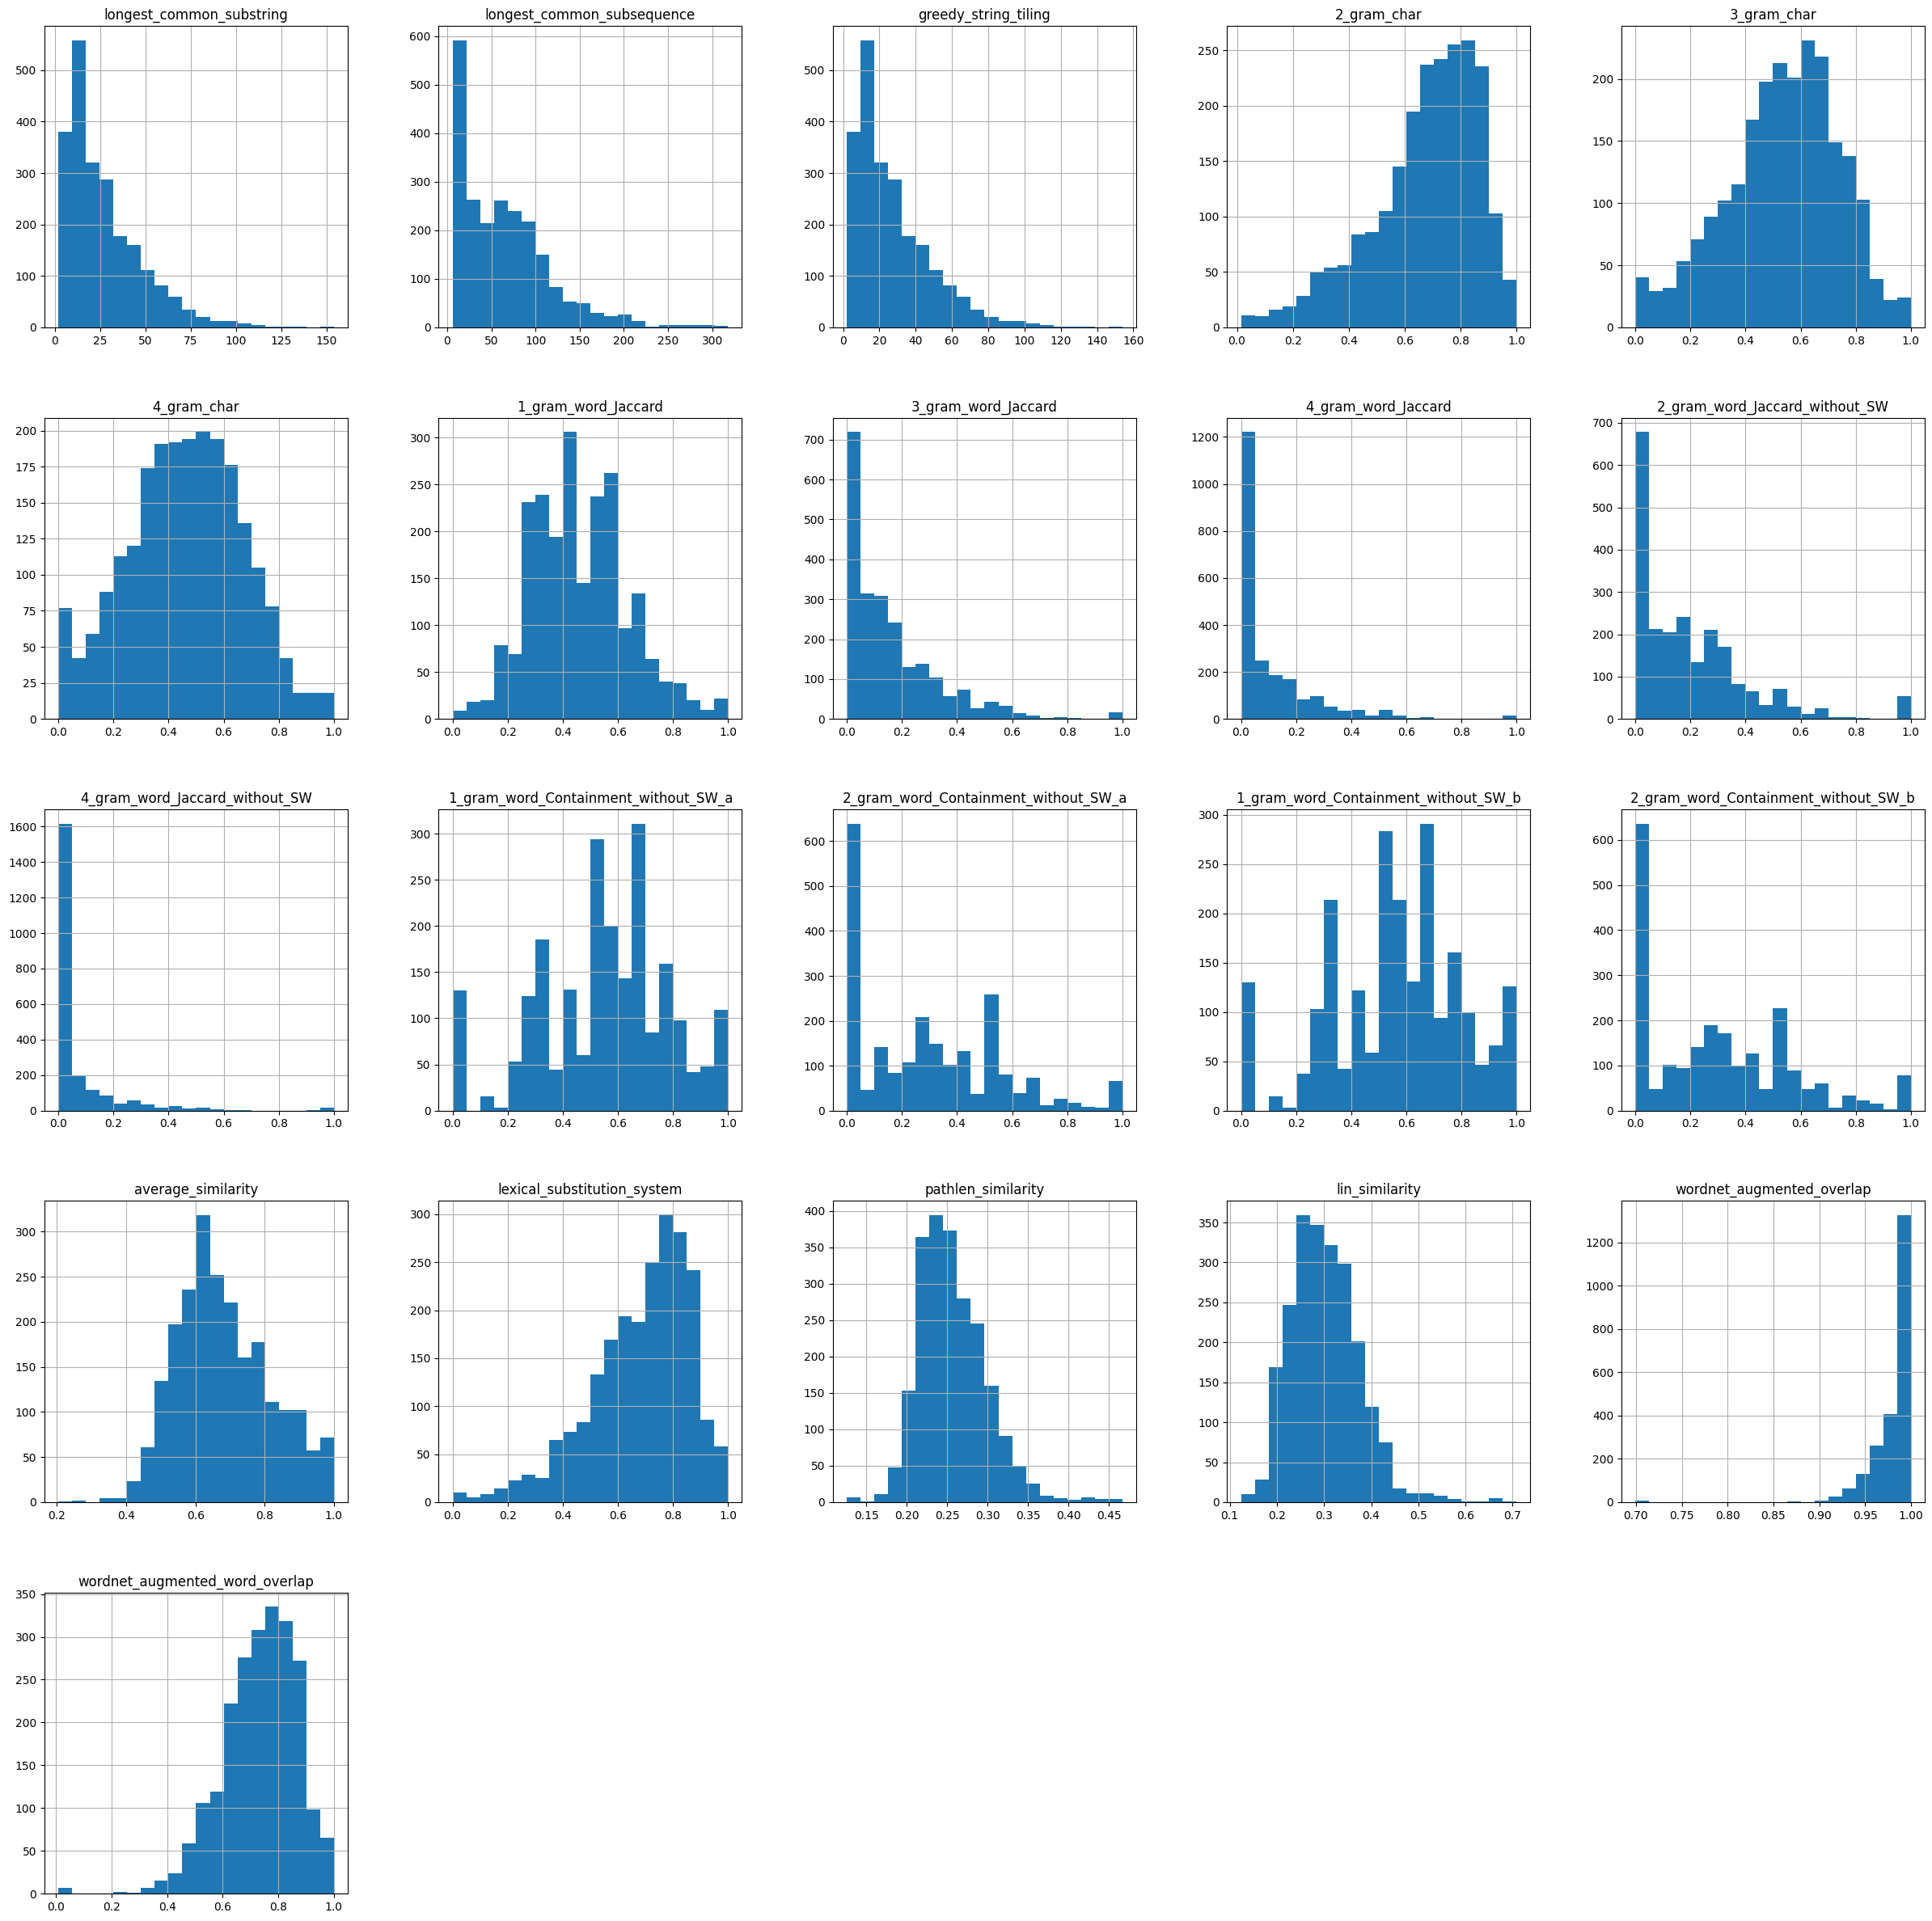

In [240]:
_=features_train.hist(bins=20,figsize=(30,30))

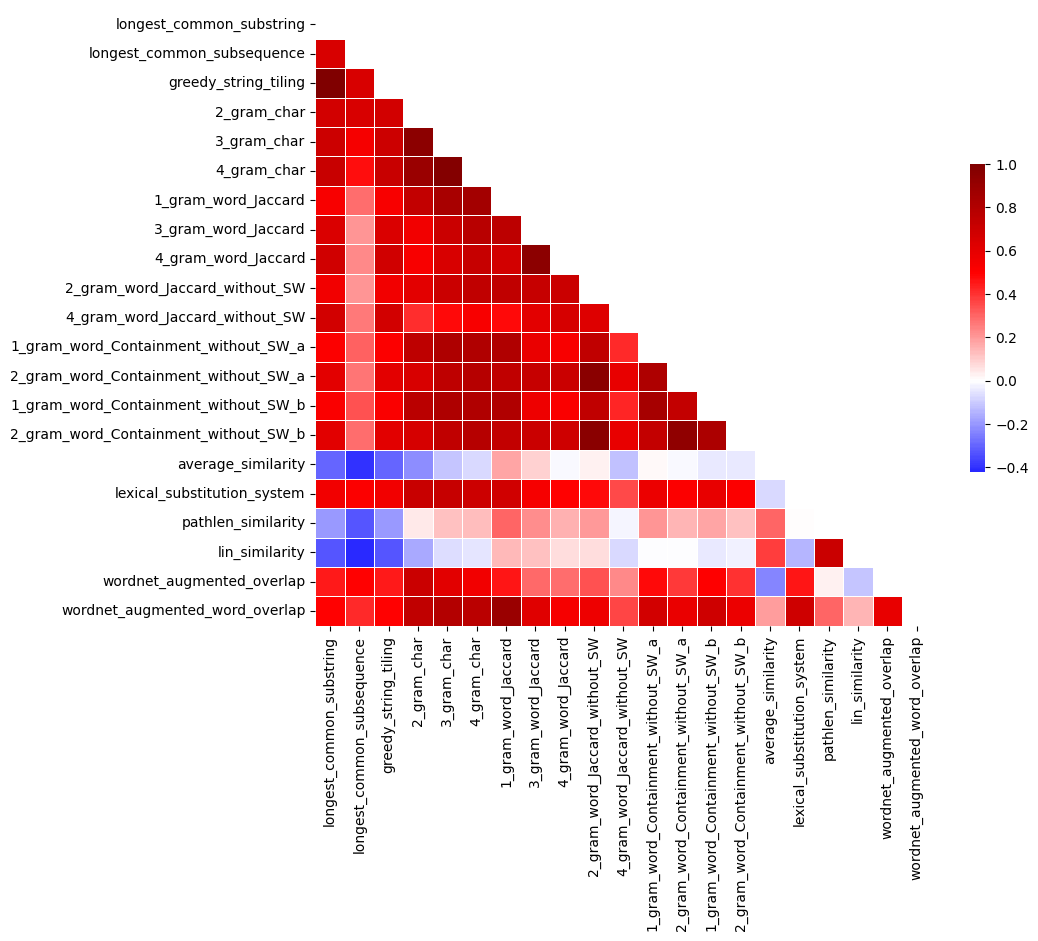

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr = features_train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Feature Preprocessing

In [239]:
features_train = pd.read_csv('./features/features_train.csv')

In [241]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method='yeo-johnson')

for col in ["longest_common_substring", "longest_common_subsequence", "greedy_string_tiling",'3_gram_word_Jaccard', '4_gram_word_Jaccard', '2_gram_word_Jaccard_without_SW', '2_gram_word_Jaccard_without_SW', "pathlen_similarity", "lin_similarity"]:
    features_train[col] = np.log1p(features_train[col])


features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.fit_transform(features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])


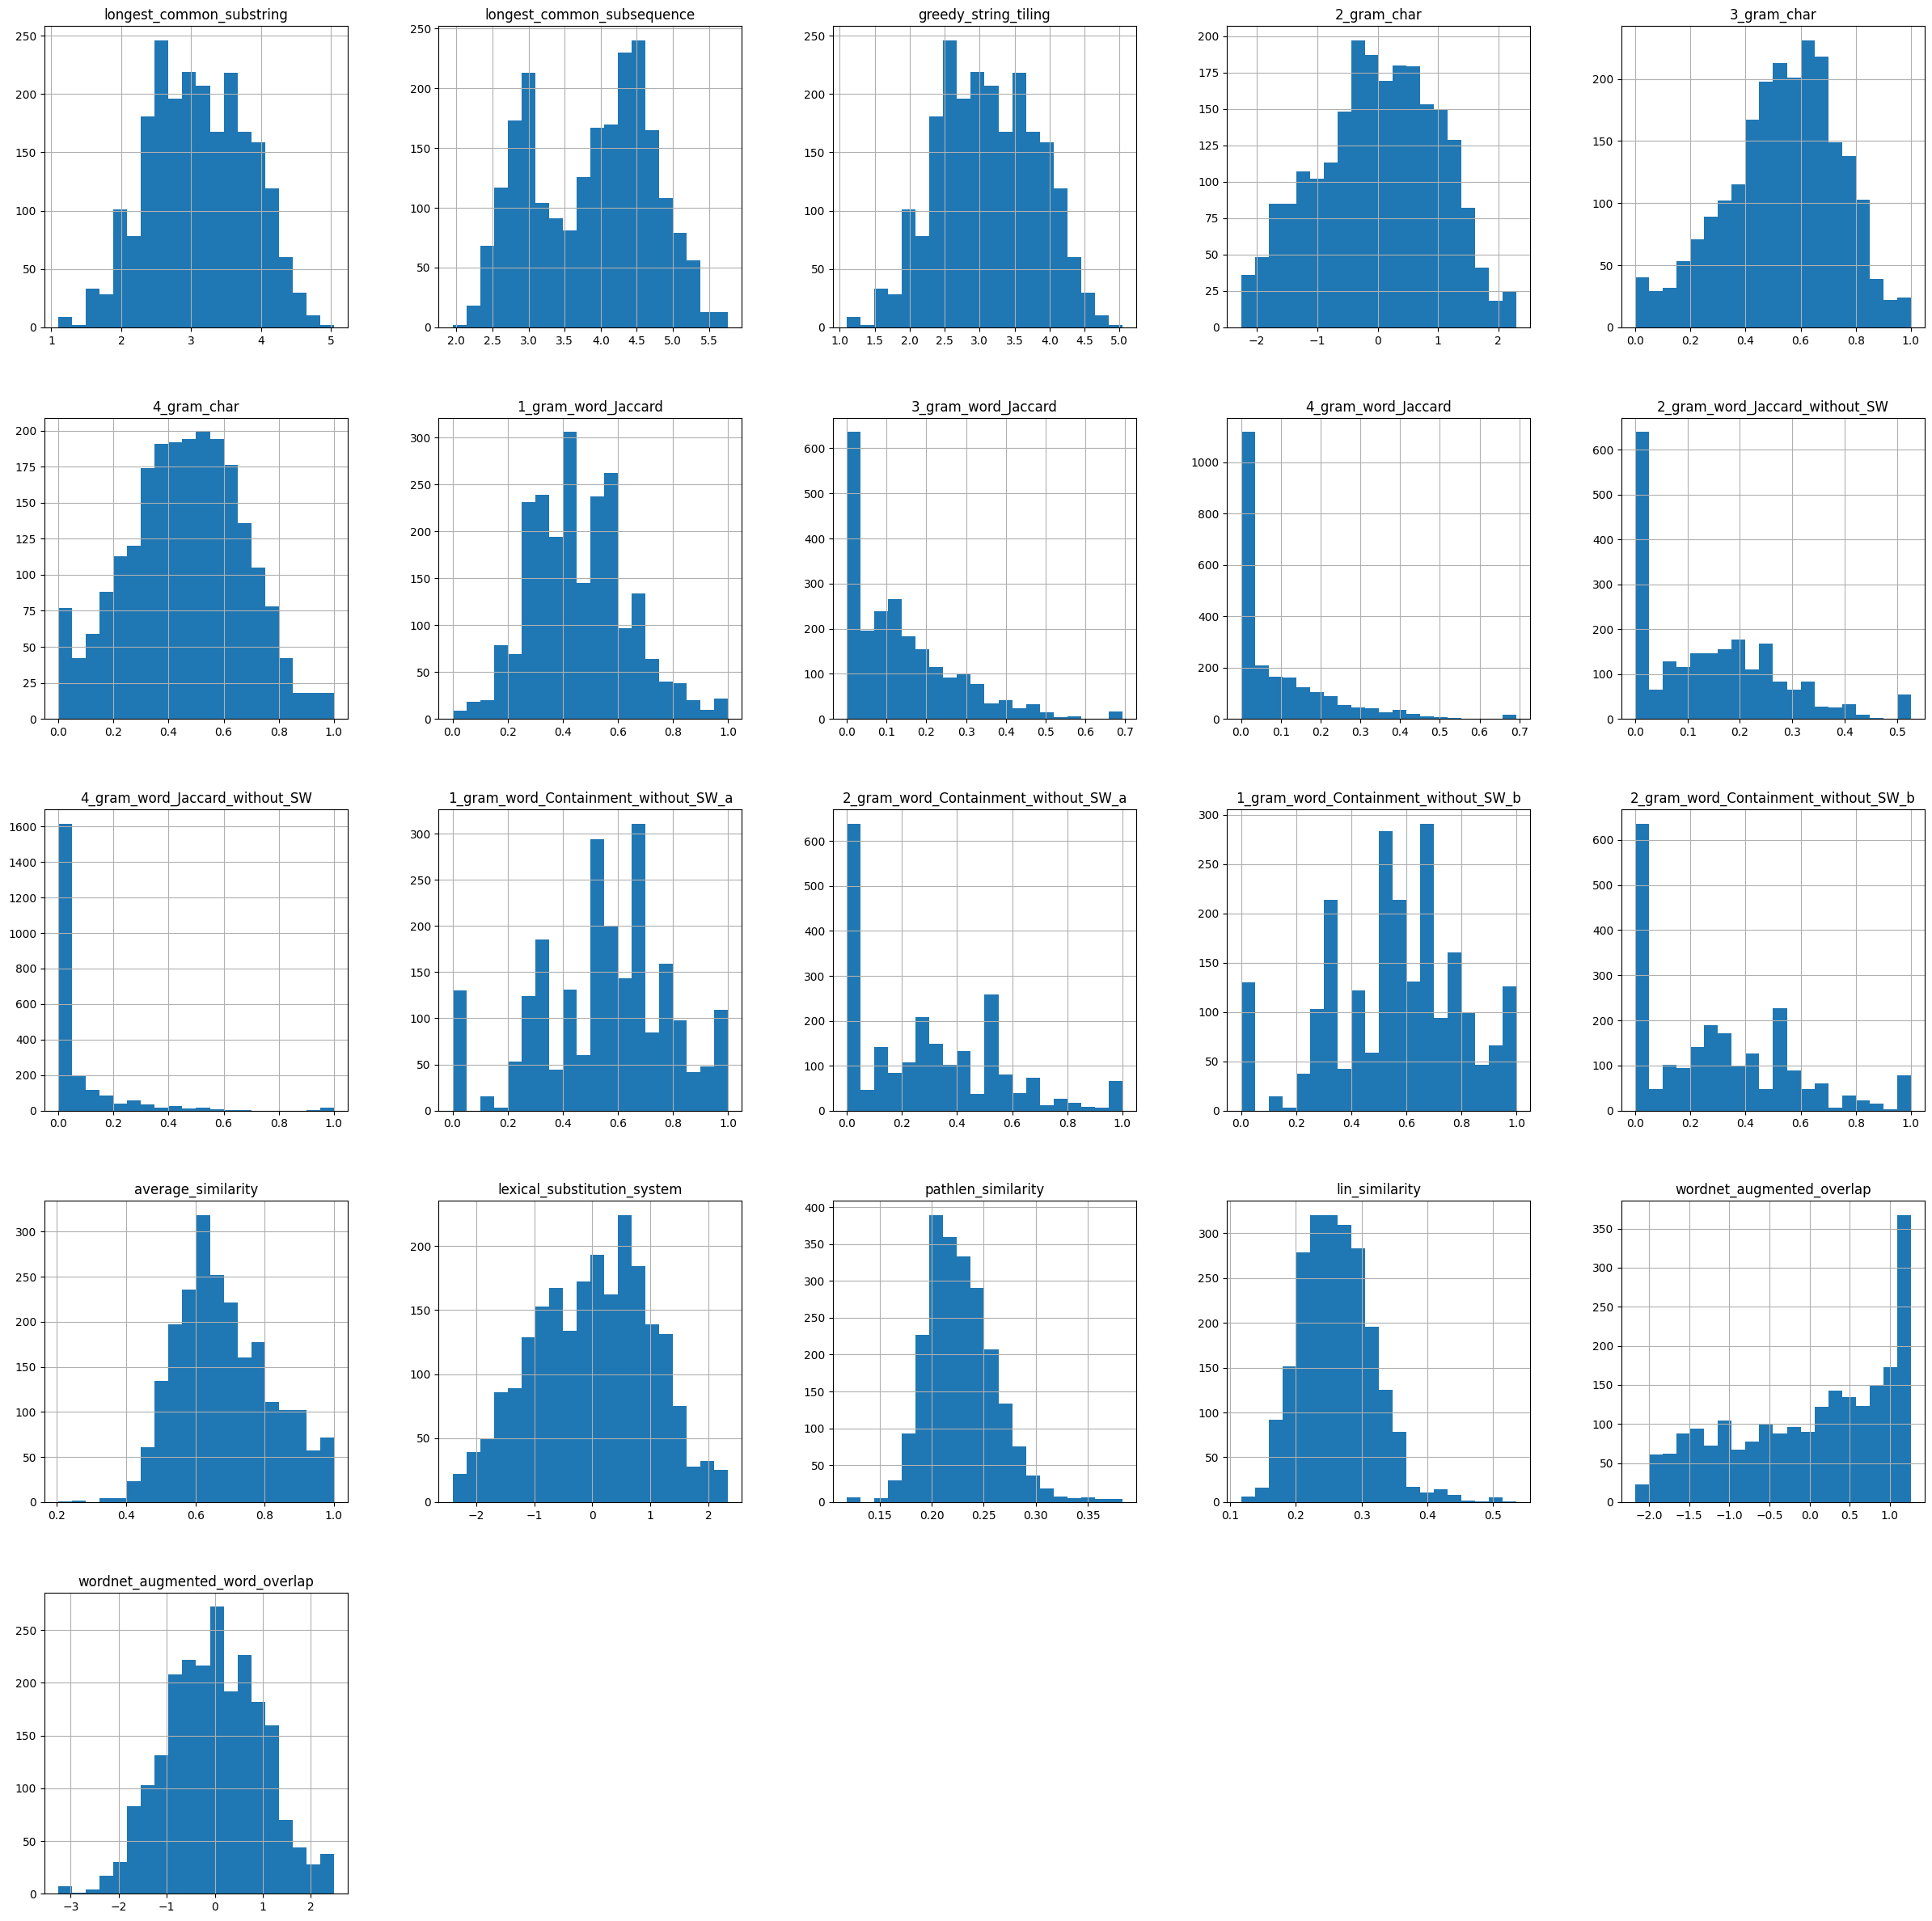

In [242]:
_=features_train.hist(bins=20,figsize=(30,30))

# **7. Model Training**

In this section, we will implement and train three different types of classifiers to .

In [243]:
from sklearn.utils import shuffle

features_train_shuffled, score_shuffled = shuffle(features_train, train_data["score"], random_state=42)

## 7.1. Linear Regression

The first model we implemented is the Linear Regression model. We selected this model due to it was used in the UKP paper [1]. We followed their same "process" using a 10-fold cross-validation.

In [244]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
import numpy as np

def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

pearson_scorer = make_scorer(pearson_corr, greater_is_better=True)

# Linear Regression Model
linear_model = LinearRegression()
# Cross-validation
linear_scores = cross_val_score(linear_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Linear Regression - Pearson Correlation Scores:", linear_scores)
print("Linear Regression - Mean Pearson Correlation:", linear_scores.mean())

Linear Regression - Pearson Correlation Scores: [0.79067158 0.79711264 0.81886028 0.87932078 0.79752676 0.85031404
 0.79156674 0.82795278 0.86057769 0.85600727]
Linear Regression - Mean Pearson Correlation: 0.8269910549507301


## 7.2. Random Forest Regressor

The second model we implemented is the Random Forest Regressor. We selected this model based on our judgement and the good performance generally of tree models in this type of task.

**Explicar hyperparametres usats i per què els hem seleccionat**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Random Forest Parameters
rf_params = {
    "n_estimators": [100, 200, 400],
    "max_depth": [15, 20, 25], #None crec que funciona millor
    "min_samples_split": [2, 5]
}

"""
rf_params = {
    "n_estimators": [400],
    "max_depth": [20], #None crec que funciona millor
    "min_samples_split": [2]
}

"""

# Random Forest Model
rf_model = RandomForestRegressor(random_state=0)

# Grid Search for Random Forest
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring=pearson_scorer, n_jobs=-1)
rf_grid.fit(features_train_shuffled, score_shuffled)

# Best Model and Parameters
rf_best_model = rf_grid.best_estimator_
rf_best_params = rf_grid.best_params_

# Cross-validation with the best model
rf_best_scores = cross_val_score(rf_best_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Random Forest - Best Parameters:", rf_best_params)
print("Random Forest - Pearson Correlation Scores:", rf_best_scores)
print("Random Forest - Mean Pearson Correlation:", rf_best_scores.mean())

Random Forest - Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 400}
Random Forest - Pearson Correlation Scores: [0.82983345 0.83639195 0.85371879 0.88918312 0.81460759 0.87779118
 0.83042946 0.84786753 0.89376186 0.88588548]
Random Forest - Mean Pearson Correlation: 0.8559470391888582


## 7.3. Gradient Boosting

The third and last model we implemented is a Gradient Boosting model. This model **... explicar per sobre què fa i com funciona...**.

**Explicar hyperparametres usats i per què els hem seleccionat**

In [246]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Parameters
gb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [5, 10, 15, 20],
    "min_samples_split": [2, 5, 7],
    "subsample": [0.5, 1.0]
}

"""
gb_params = {
    "learning_rate": [0.01],
    "n_estimators": [400],
    "max_depth": [10],
    "min_samples_split": [2],
    "subsample": [0.5]
}
"""

# Gradient Boosting Model
gb_model = GradientBoostingRegressor(random_state=0)

# Grid Search for Gradient Boosting
gb_grid = GridSearchCV(gb_model, gb_params, cv=10, scoring=pearson_scorer, n_jobs=-1)
gb_grid.fit(features_train_shuffled, score_shuffled)

# Best Model and Parameters
gb_best_model = gb_grid.best_estimator_
gb_best_params = gb_grid.best_params_

# Cross-validation with the best model
gb_best_scores = cross_val_score(gb_best_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Gradient Boosting - Best Parameters:", gb_best_params)
print("Gradient Boosting - Pearson Correlation Scores:", gb_best_scores)
print("Gradient Boosting - Mean Pearson Correlation:", gb_best_scores.mean())

Gradient Boosting - Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 400, 'subsample': 0.5}
Gradient Boosting - Pearson Correlation Scores: [0.82667902 0.83435788 0.86286915 0.88594965 0.83732248 0.88483836
 0.83766722 0.85251214 0.88837161 0.89043383]
Gradient Boosting - Mean Pearson Correlation: 0.860100133512147


## **8. Model Selection**

In [247]:
models_summary = {
    "Linear Regression": {"Mean Pearson CV Score": linear_scores.mean()},
    "Random Forest": {"Mean Pearson CV Score": rf_best_scores.mean()},
    "Gradient Boosting": {"Mean Pearson CV Score": gb_best_scores.mean()},
}

models_df = pd.DataFrame(models_summary).T
print(models_df)

best_model_name = models_df["Mean Pearson CV Score"].idxmax()
best_model_score = models_df["Mean Pearson CV Score"].max()

print(f"Best Model: {best_model_name} with a Mean Pearson CV Score of {best_model_score}")


                   Mean Pearson CV Score
Linear Regression               0.826991
Random Forest                   0.855947
Gradient Boosting               0.860100
Best Model: Gradient Boosting with a Mean Pearson CV Score of 0.860100133512147


In [248]:
model = gb_best_model

# **9. Test Set Evaluation**

Once selected the best model, we computed the pearson correlation obtained with the best model. For that, we first needed to compute the features from the test data, preprocess some of the features like we did with the train data, and predict the similarity scores with the best model.

In [ ]:
features_test = compute_features(test_data)

In [199]:
features_test.to_csv("./features/features_test.csv", index=False)

In [249]:
features_test = pd.read_csv("./features/features_test.csv")

In [250]:
for col in ["longest_common_substring", "longest_common_subsequence", "greedy_string_tiling",'3_gram_word_Jaccard', '4_gram_word_Jaccard', '2_gram_word_Jaccard_without_SW', '2_gram_word_Jaccard_without_SW', "pathlen_similarity", "lin_similarity"]:
    features_test[col] = np.log1p(features_test[col])

features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.transform(features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])

In [251]:
y_true = test_data["score"]

y_pred = model.predict(features_test)
pearson_corr = pearsonr(y_true, y_pred)[0]
print("Pearson Correlation:", pearson_corr)

Pearson Correlation: 0.751057884093215


# **10. Feature Importance Analysis**

We believe it is important to know which of the features we implemented had more importance in the final model to classify each pair of sentences. A continuación we show a bar chart showing each feature sorted by their importance

In [252]:
# Extract the importance from each feature
importances = model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': features_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


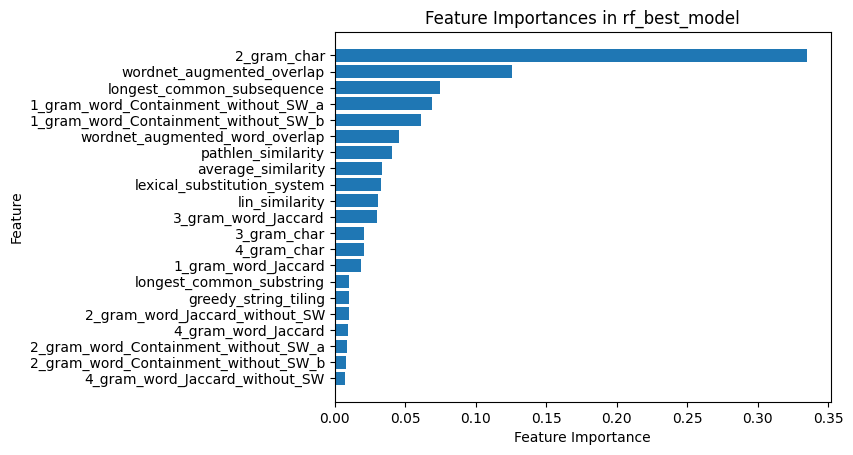

In [253]:
import matplotlib.pyplot as plt

# Plot the bar chart
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in rf_best_model')
plt.gca().invert_yaxis() # Most important feature at the top
plt.show()

**Explicar la bar chart, explicar en concret per què algunes features van molt bé i altres molt malament, explicar en general si lexical features semblen anar millor que features sintactiques, o si mixtes van millor**

# **11. Analysis with different texts**

In [254]:
pearson_results = {}

for dataset_name, group in test_data.groupby("dataset_name"):
    y_true = group["score"]

    features_group = compute_features(group)

    for col in ["longest_common_substring", "longest_common_subsequence", "greedy_string_tiling",'3_gram_word_Jaccard', '4_gram_word_Jaccard', '2_gram_word_Jaccard_without_SW', '2_gram_word_Jaccard_without_SW']:
      features_group[col] = np.log1p(features_group[col])

    features_group[["2_gram_char", "lexical_substitution_system"]] = power_transformer.transform(features_group[["2_gram_char", "lexical_substitution_system"]])

    y_pred = model.predict(features_group)

    pearson_corr = pearsonr(y_true, y_pred)[0]

    pearson_results[dataset_name] = pearson_corr

    print(f"Dataset: {dataset_name}, Pearson Correlation: {pearson_corr}")

NameError: name 'compute_features' is not defined

# **12. Comparison with Official Results**

# **13. Conclusions**

# **References**

[1]: [UKP: Computing Semantic Textual Similarity by Combining Multiple Content Similarity Measures](https://aclanthology.org/S12-1059) (Bär et al., SemEval-*SEM 2012)